## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
#import sys
#import os
#sys.path.append(os.path.abspath('./../'))

In [2]:
# from <TC_Env> import <TicTacToe> - import your class from environment file
import TCGame_Env1 as environment
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt
import copy

In [3]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [4]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [5]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [6]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy

def epsilon_greedy(state, time):
    epsilon = - 1/ (1 + np.exp((-time+7500000)/1700000)) + 1
    z = np.random.random()
    action =()
    
    if(len(valid_actions(state))!=0):
        if z > epsilon:
            action = max(Q_dict[Q_state(state)],key=Q_dict[Q_state(state)].get)   #Exploitation: this gets the action corresponding to max q-value of current state
        else:
            action = random.choice(valid_actions(state))    #Exploration: randomly choosing and action 
            
    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [7]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)

Q_dict = collections.defaultdict(dict)

States_track = collections.defaultdict(dict)

In [8]:
# Initialise states to be tracked
#This function will initialise the 7 Q-values which need to be tracked for checking convergence

#iters = []                            #the x-axis of convergence graphs

def initialise_tracking_states():
    sample_q_values = [('2-x-9-x-x-x-8-x-1',(3,5)),('x-x-6-7-x-3-x-x-4',(4,5)),('1-x-x-x-6-x-x-x-x',(8,8)),('5-x-9-6-4-8-7-3-2',(1,1)),('4-x-8-x-x-x-x-5-9',(6,1)),('x-x-6-7-x-3-x-x-4',(0,1))]    #select any Q-values
    for q_values in sample_q_values:
        state  = q_values[0]
        action = q_values[1]
        States_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every 2000th episode  

In [9]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [10]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [12]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [13]:
#EPISODES = 1000000
EPISODES = 15000000
STEPS = 8
LR = 0.01
GAMMA = 0.91


#threshold = 1000     #every these many episodes, the 6 Q-values will be stored/appended (convergence graphs)
#policy_threshold = 3000    #every these many episodes, the Q-dict will be updated
threshold = 2000     #every these many episodes, the 6 Q-values will be stored/appended (convergence graphs)
policy_threshold = 3000    #every these many episodes, the Q-dict will be updated

### Q-update loop ---write your code here

In [14]:
start_time = time.time()

for episode in range(EPISODES):
    ##### Start writing your code from the next line
    
    env = environment.TicTacToe()
    
    initial_state = env.state    #for the purpose of tracking reward
    curr_state = copy.deepcopy(env.state)
    
    time_step = 0
    total_reward = 0
    termination = False
    
    add_to_dict(curr_state)
    
    while (time_step < STEPS and not(termination)):    #the episode will run only for a few steps and not infinitely
               
        curr_action = epsilon_greedy(curr_state, episode)
        
        next_state, reward, termination = env.step(copy.deepcopy(curr_state), curr_action)
        
        add_to_dict(next_state)
        
        if not(termination):
            # UPDATE RULE
            max_next = max(Q_dict[Q_state(next_state)],key=Q_dict[Q_state(next_state)].get)   #this gets the action corresponding to max q-value of next state
            Q_dict[Q_state(curr_state)][curr_action] += LR * ((reward + (GAMMA*(Q_dict[Q_state(next_state)][max_next]))) - Q_dict[Q_state(curr_state)][curr_action] )
        else:
            Q_dict[Q_state(curr_state)][curr_action] += LR * ((reward ) - Q_dict[Q_state(curr_state)][curr_action] )
        
        curr_state = next_state
        
        total_reward += reward
        
        time_step += 1
                
    #TRACKING Q-VALUES
    if (episode == threshold-1):        #at the 1999th episode
        initialise_tracking_states()
      
    if ((episode+1) % threshold) == 0:   #every 2000th episode
        save_tracking_states()
        save_obj(States_track,'States_tracked')   
    
    #SAVING POLICY
    if ((episode+1)% policy_threshold ) == 0:  #every 30000th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy')         

elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

#### Check the Q-dictionary

In [20]:
Q_dict['4-x-8-x-x-x-x-5-9']

{(1, 1): -0.0199,
 (1, 3): 0.490099501,
 (1, 7): 0,
 (3, 1): -0.117891,
 (3, 3): -0.03949499,
 (3, 7): 0,
 (4, 1): -0.01,
 (4, 3): 0,
 (4, 7): -0.00909,
 (5, 1): 0,
 (5, 3): -0.029701,
 (5, 7): -0.03940399,
 (6, 1): 0.1,
 (6, 3): -0.03940399,
 (6, 7): -0.21671299000000002}

In [21]:
len(Q_dict)

4405531

In [37]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
print(max(Q_dict['4-x-8-x-x-x-x-5-9'],key=Q_dict['4-x-8-x-x-x-x-5-9'].get))
# Action Should be either (1,3) or (6,1) 

(1, 3)


#### Check the states tracked for Q-values convergence
(non-evaluative)

# Write the code for plotting the graphs for state-action pairs tracked

In [ ]:
#with open('States_tracked.pkl', 'rb') as handle:
    #States_track = pickle.load(handle)

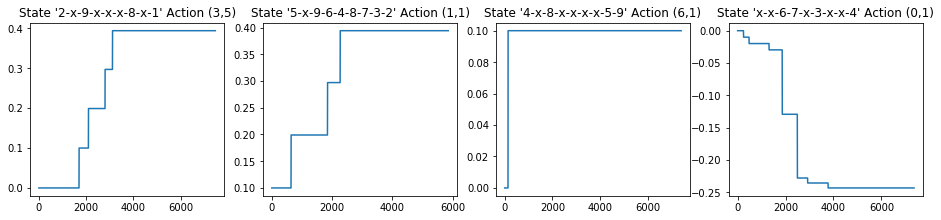

In [29]:
plt.figure(0,figsize=(16,7))
plt.subplot(241)
plt.title("State '2-x-9-x-x-x-8-x-1' Action (3,5)")
plt.plot(States_track['2-x-9-x-x-x-8-x-1'][(3,5)])
plt.subplot(242)
plt.title("State '5-x-9-6-4-8-7-3-2' Action (1,1)")
plt.plot(States_track['5-x-9-6-4-8-7-3-2'][(1,1)])
plt.subplot(243)
plt.title("State '4-x-8-x-x-x-x-5-9' Action (6,1)")
plt.plot(States_track['4-x-8-x-x-x-x-5-9'][(6,1)])
plt.subplot(244)
plt.title("State 'x-x-6-7-x-3-x-x-4' Action (0,1)")
plt.plot(States_track['x-x-6-7-x-3-x-x-4'][(0,1)])
plt.show()

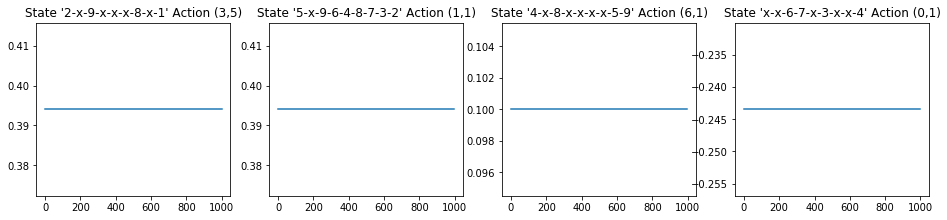

In [30]:
plt.figure(0,figsize=(16,7))
plt.subplot(241)
plt.title("State '2-x-9-x-x-x-8-x-1' Action (3,5)")
plt.plot(States_track['2-x-9-x-x-x-8-x-1'][(3,5)][-1000:])
plt.subplot(242)
plt.title("State '5-x-9-6-4-8-7-3-2' Action (1,1)")
plt.plot(States_track['5-x-9-6-4-8-7-3-2'][(1,1)][-1000:])
plt.subplot(243)
plt.title("State '4-x-8-x-x-x-x-5-9' Action (6,1)")
plt.plot(States_track['4-x-8-x-x-x-x-5-9'][(6,1)][-1000:])
plt.subplot(244)
plt.title("State 'x-x-6-7-x-3-x-x-4' Action (0,1)")
plt.plot(States_track['x-x-6-7-x-3-x-x-4'][(0,1)][-1000:])
plt.show()

### Epsilon - decay check

In [31]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

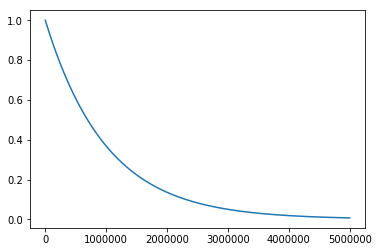

In [32]:
plt.plot(time, epsilon)
plt.show()